# Start-to-Finish Example: Head-On Black Hole Collision

### Author: Zach Etienne

## This module implements a basic numerical relativity code to merge two black holes in *spherical coordinates*

### Here we place the black holes initially on the $z$-axis, so the entire simulation is axisymmetric about the $\phi$-axis. Not sampling in the $\phi$ direction greatly speeds up the simulation.

<font color='green'>**This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution *after a short numerical evolution of the initial data* (see plot at bottom), and all quantities have been validated against the [original SENR code](https://bitbucket.org/zach_etienne/nrpy).**</font>

### NRPy+ Source Code for this module: 
1. [BSSN/BrillLindquist.py](../edit/BSSN/BrillLindquist.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb): Brill-Lindquist initial data; sets all ADM variables in Cartesian basis: 
1. [BSSN/ADM_Exact_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Exact_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Exact_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): Spherical/Cartesian ADM$\to$Curvilinear BSSN converter function, for which exact expressions are given for ADM quantities.
1. [BSSN/BSSN_ID_function_string.py](../edit/BSSN/BSSN_ID_function_string.py): Sets up the C code string enabling initial data be set up in a point-by-point fashion
1. [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates
1. [BSSN/BSSN_RHSs.py](../edit/BSSN/BSSN_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb): Generates the right-hand sides for the BSSN evolution equations in singular, curvilinear coordinates
1. [BSSN/BSSN_gauge_RHSs.py](../edit/BSSN/BSSN_gauge_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb): Generates the right-hand sides for the BSSN gauge evolution equations in singular, curvilinear coordinates

Here we use NRPy+ to generate the C source code necessary to set up initial data for two black holes (Brill-Lindquist, [Brill & Lindquist, Phys. Rev. 131, 471, 1963](https://journals.aps.org/pr/abstract/10.1103/PhysRev.131.471); see also Eq. 1 of [Brandt & Brügmann, arXiv:gr-qc/9711015v1](https://arxiv.org/pdf/gr-qc/9711015v1.pdf)). Then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. (**Step 2** below) <font color='green'>Set gridfunction values to initial data (**[documented in previous start-to-finish module](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_two_BH_initial_data.ipynb)**).</font>
1. Evolve the initial data forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. (**Step 3A** below) <font color='green'>Evaluate BSSN RHS expressions.</font>
    1. (**Step 4** below) Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
    1. (**Step 5** below) <font color='green'>Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint</font>
1. (**Step 3B** below) At the end of each iteration in time, output the <font color='green'>Hamiltonian constraint violation</font>. (This is in Step 3B, because Step 4 requires that *all* gridfunctions be defined.)
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

In [1]:
# First we import needed core NRPy+ modules
from outputC import *
import NRPy_param_funcs as par
import grid as gri
import loop as lp
import indexedexp as ixp
import finite_difference as fin
import reference_metric as rfm

# Set spatial dimension (must be 3 for BSSN)
DIM = 3
par.set_parval_from_str("grid::DIM",DIM)

# Then we set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","Spherical")
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Then we set the phi axis to be the symmetry axis; i.e., axis "2", corresponding to the i2 direction. 
#      This sets all spatial derivatives in the phi direction to zero.
par.set_parval_from_str("indexedexp::symmetry_axes","2")

#################
# Next output C headers related to the numerical grids we just set up:
#################

# First output the coordinate bounds xxmin[] and xxmax[]:
with open("BSSN/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")

# Next output the proper distance between gridpoints in given coordinate system.
#     This is used to find the minimum timestep.
dxx     = ixp.declarerank1("dxx",DIM=3)
ds_dirn = rfm.ds_dirn(dxx)
outputC([ds_dirn[0],ds_dirn[1],ds_dirn[2]],["ds_dirn0","ds_dirn1","ds_dirn2"],"BSSN/ds_dirn.h")

# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "BSSN/xxCart.h")

Wrote to file "BSSN/ds_dirn.h"
Wrote to file "BSSN/xxCart.h"


## Step 2: Import Brill-Lindquist ADM initial data C function from the [BSSN.BrillLindquist](../edit/BSSN/BrillLindquist.py) NRPy+ module

The [BSSN.BrillLindquist](../edit/BSSN/BrillLindquist.py) NRPy+ module does the following:

1. Set up Brill-Lindquist initial data [ADM](https://en.wikipedia.org/wiki/ADM_formalism) quantities in the **Cartesian basis**, as [documented here](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb). 
1. Convert the ADM **Cartesian quantities** to **BSSN quantities in the desired Curvilinear basis** (set by reference_metric::CoordSystem), as [documented here](Tutorial-ADM_Initial_Data-Converting_ADMCartesian_to_BSSNCurvilinear.ipynb).
1. Sets up the standardized C function for setting all BSSN Curvilinear gridfunctions in a pointwise fashion, as [written here](../edit/BSSN/BSSN_ID_function_string.py), and returns the C function as a Python string.

In [2]:
import BSSN.BrillLindquist as bl
returnfunction = bl.BrillLindquist()
# Now output the Brill-Lindquist initial data to file:
with open("BSSN/BrillLindquist.h","w") as file:
    file.write(bl.returnfunction)

## Step 3A: Output BSSN RHS expressions

In [3]:
import BSSN.BSSN_RHSs as rhs
import BSSN.BSSN_gauge_RHSs as gaugerhs
# Set the *covariant*, second-order Gamma-driving shift condition
par.set_parval_from_str("BSSN.BSSN_gauge_RHSs::ShiftEvolutionOption", "GammaDriving2ndOrder_Covariant")
rhs.BSSN_RHSs()
gaugerhs.BSSN_gauge_RHSs()

import time
print("Generating C code for BSSN RHSs in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
start = time.time()

BSSN_evol_rhss = [ \
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD00"),rhs=rhs.a_rhsDD[0][0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD01"),rhs=rhs.a_rhsDD[0][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD02"),rhs=rhs.a_rhsDD[0][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD11"),rhs=rhs.a_rhsDD[1][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD12"),rhs=rhs.a_rhsDD[1][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD22"),rhs=rhs.a_rhsDD[2][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","alpha"),rhs=gaugerhs.alpha_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU0"),rhs=gaugerhs.bet_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU1"),rhs=gaugerhs.bet_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU2"),rhs=gaugerhs.bet_rhsU[2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","cf"),   rhs=rhs.cf_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD00"),rhs=rhs.h_rhsDD[0][0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD01"),rhs=rhs.h_rhsDD[0][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD02"),rhs=rhs.h_rhsDD[0][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD11"),rhs=rhs.h_rhsDD[1][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD12"),rhs=rhs.h_rhsDD[1][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD22"),rhs=rhs.h_rhsDD[2][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU0"),rhs=rhs.lambda_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU1"),rhs=rhs.lambda_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU2"),rhs=rhs.lambda_rhsU[2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","trK"),  rhs=rhs.trK_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU0"),rhs=gaugerhs.vet_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU1"),rhs=gaugerhs.vet_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU2"),rhs=gaugerhs.vet_rhsU[2]) ]

import BSSN.BSSN_quantities as Bq
Bq.BSSN_basic_tensors()
betaU = Bq.betaU
BSSN_RHSs_string = fin.FD_outputC("returnstring",BSSN_evol_rhss, params="outCverbose=False",upwindcontrolvec=betaU)
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

with open("BSSN/BSSN_RHSs.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+BSSN_RHSs_string))

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Generating C code for BSSN RHSs in Spherical coordinates.
Finished in 56.05877423286438 seconds.


## Step 3B: We will validate that the Brill-Lindquist black hole simulation satisfies the Hamiltonian constraint, modulo numerical finite differencing error

In [4]:
# First register the Hamiltonian as a gridfunction.
H = gri.register_gridfunctions("AUX","H")
# Then define the Hamiltonian constraint and output the optimized C code.
import BSSN.BSSN_constraints as bssncon
bssncon.output_C__Hamiltonian_h(add_T4UUmunu_source_terms=False)

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Generating optimized C code for Hamiltonian constraint. May take a while, depending on CoordSystem.
Finished in 10.582174301147461 seconds.
Output C implementation of Hamiltonian constraint to BSSN/Hamiltonian.h


## Step 4: Apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial module](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

In [5]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions()

Wrote to file "CurviBoundaryConditions/gridfunction_defines.h"
Wrote to file "CurviBoundaryConditions/set_parity_conditions.h"
Wrote to file "CurviBoundaryConditions/xxCart.h"
Wrote to file "CurviBoundaryConditions/xxminmax.h"
Wrote to file "CurviBoundaryConditions/Cart_to_xx.h"


## Step 5: Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)), as [documented in the corresponding NRPy+ tutorial module](Tutorial-BSSN-Enforcing_Determinant_gammabar_equals_gammahat_Constraint.ipynb)

Applying curvilinear boundary conditions should affect the initial data at the outer boundary, and will in general cause the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint to be violated there. Thus after we apply these boundary conditions, we must always call the routine for enforcing the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint:

In [6]:
import BSSN.Enforce_Detgammabar_Constraint as EGC
EGC.output_Enforce_Detgammabar_Constraint_Ccode()

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Output C implementation of det(gammabar) constraint to file BSSN/enforce_detgammabar_constraint.h


# BrillLindquist_Playground.c: The Main C Code

In [7]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("BSSN/NGHOSTS.h", "w") as file:
    file.write("// Part P0: Set the number of ghost zones, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    # Upwinding in BSSN requires that NGHOSTS = FD_CENTDERIVS_ORDER/2 + 1 <- Notice the +1.
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2)+1)+"\n")

In [8]:
%%writefile BSSN/BrillLindquist_Playground.c

// Step P1: Import needed header files
#include "NGHOSTS.h" // A NRPy+-generated file, which is set based on FD_CENTDERIVS_ORDER.
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"

// Step P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Step P2a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

// Step P3: Set free parameters
// Step P3a: Free parameters for the numerical grid
// Cartesian coordinates parameters
const REAL xmin = -10.,xmax=10.;
const REAL ymin = -10.,ymax=10.;
const REAL zmin = -10.,zmax=10.;

// Spherical coordinates parameter
const REAL RMAX    = 7.5;
// SinhSpherical coordinates parameters
const REAL AMPL    = 7.5;
const REAL SINHW   = 0.125;
// Cylindrical coordinates parameters
const REAL ZMIN   = -7.5;
const REAL ZMAX   =  7.5;
const REAL RHOMAX =  7.5;
// Time coordinate parameters
const REAL t_final =  7.5; /* Final time is set so that at t=t_final, 
                            * data at the origin have not been corrupted 
                            * by the approximate outer boundary condition */
REAL CFL_FACTOR = 0.5; // Set the CFL Factor

// Step P3b: Free parameters for the spacetime evolution
const REAL eta = 1.0; // Gamma-driving shift condition parameter.

// Step P4: Implement the algorithm for upwinding.
//          *NOTE*: This upwinding is backwards from
//          usual upwinding algorithms, because the
//          upwinding control vector in BSSN (the shift)
//          acts like a *negative* velocity.
#define UPWIND_ALG(UpwindVecU) UpwindVecU > 0.0 ? 1.0 : 0.0

// Step P5: Set free parameters for the (Brill-Lindquist) initial data
const REAL BH1_posn_x = 0.0,BH1_posn_y = 0.0,BH1_posn_z = +0.5;
const REAL BH2_posn_x = 0.0,BH2_posn_y = 0.0,BH2_posn_z = -0.5;
const REAL BH1_mass = 0.5,BH2_mass = 0.5;

// Step P6: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//          data in a 1D array. In this case, consecutive values of "i" 
//          (all other indices held to a fixed value) are consecutive in memory, where 
//          consecutive values of "j" (fixing all other indices) are separated by 
//          Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//          "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

// Step P7: Set #define's for BSSN gridfunctions. C code generated above
#include "../CurviBoundaryConditions/gridfunction_defines.h"

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)

void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "../CurviBoundaryConditions/xxCart.h"
}

// Step P8: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "../CurviBoundaryConditions/curvilinear_parity_and_outer_boundary_conditions.h"

#include "enforce_detgammabar_constraint.h"

// Step P9: Find the CFL-constrained timestep
REAL find_timestep(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],REAL *xx[3], const REAL CFL_FACTOR) {
  const REAL dxx0 = dxx[0], dxx1 = dxx[1], dxx2 = dxx[2];
  REAL dsmin = 1e38; // Start with a crazy high value... close to the largest number in single precision.
  LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
    const REAL xx0 = xx[0][i0], xx1 = xx[1][i1], xx2 = xx[2][i2];
    REAL ds_dirn0, ds_dirn1, ds_dirn2;
#include "ds_dirn.h"
#define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
    // Set dsmin = MIN(dsmin, ds_dirn0, ds_dirn1, ds_dirn2);
    dsmin = MIN(dsmin,MIN(ds_dirn0,MIN(ds_dirn1,ds_dirn2)));
  }
  return dsmin*CFL_FACTOR;
}

// Contains BSSN_ID() for BrillLindquist initial data
#include "BrillLindquist.h"

// Step P10: Declare the function for the exact solution. time==0 corresponds to the initial data.
void initial_data(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *in_gfs) {
#pragma omp parallel for
  LOOP_REGION(0,Nxx_plus_2NGHOSTS[0], 0,Nxx_plus_2NGHOSTS[1], 0,Nxx_plus_2NGHOSTS[2]) {
    const int idx = IDX3(i0,i1,i2);
    BSSN_ID(xx[0][i0],xx[1][i1],xx[2][i2],
            &in_gfs[IDX4pt(HDD00GF,idx)],&in_gfs[IDX4pt(HDD01GF,idx)],&in_gfs[IDX4pt(HDD02GF,idx)],
            &in_gfs[IDX4pt(HDD11GF,idx)],&in_gfs[IDX4pt(HDD12GF,idx)],&in_gfs[IDX4pt(HDD22GF,idx)],
            &in_gfs[IDX4pt(ADD00GF,idx)],&in_gfs[IDX4pt(ADD01GF,idx)],&in_gfs[IDX4pt(ADD02GF,idx)],
            &in_gfs[IDX4pt(ADD11GF,idx)],&in_gfs[IDX4pt(ADD12GF,idx)],&in_gfs[IDX4pt(ADD22GF,idx)],
            &in_gfs[IDX4pt(TRKGF,idx)],
            &in_gfs[IDX4pt(LAMBDAU0GF,idx)],&in_gfs[IDX4pt(LAMBDAU1GF,idx)],&in_gfs[IDX4pt(LAMBDAU2GF,idx)],
            &in_gfs[IDX4pt(VETU0GF,idx)],&in_gfs[IDX4pt(VETU1GF,idx)],&in_gfs[IDX4pt(VETU2GF,idx)],
            &in_gfs[IDX4pt(BETU0GF,idx)],&in_gfs[IDX4pt(BETU1GF,idx)],&in_gfs[IDX4pt(BETU2GF,idx)],
            &in_gfs[IDX4pt(ALPHAGF,idx)],&in_gfs[IDX4pt(CFGF,idx)]);
  }
}

// Step P10: Implement Hamiltonian constraint diagnostic
void Hamiltonian_constraint(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], 
                            REAL *in_gfs, REAL *aux_gfs) {
#include "Hamiltonian.h"    
}

// Step P11: Declare the function to evaluate the BSSN RHSs
void rhs_eval(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], const REAL *in_gfs,REAL *rhs_gfs) {
#include "BSSN_RHSs.h"
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    // Step 0a: Read command-line input, error out if nonconformant
    if((argc != 4 && argc != 5) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    if(argc == 5) {
        CFL_FACTOR = strtod(argv[4],NULL);
        if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
            fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
            fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
            fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
        }
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }
    const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

    // Step 0c: Allocate memory for gridfunctions
    REAL *evol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *next_in_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *aux_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k1_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k2_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k3_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k4_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0d: Set up space and time coordinates
    // Step 0d.i: Set \Delta x^i on uniform grids.
    REAL dxx[3];
    for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

    // Step 0d.ii: Set up uniform coordinate grids
    REAL *xx[3];
    for(int i=0;i<3;i++) {
        xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
        for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
            xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
        }
    }

    // Step 0d.iii: Set timestep based on smallest proper distance between gridpoints and CFL factor 
    REAL dt = find_timestep(Nxx_plus_2NGHOSTS, dxx,xx, CFL_FACTOR);
    //printf("# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of iterations in time.
                                           //Add 0.5 to account for C rounding down integers.

    // Step 0e: Find ghostzone mappings and parities:
    gz_map *bc_gz_map = (gz_map *)malloc(sizeof(gz_map)*Nxx_plus_2NGHOSTS_tot);
    parity_condition *bc_parity_conditions = (parity_condition *)malloc(sizeof(parity_condition)*Nxx_plus_2NGHOSTS_tot);
    set_up_bc_gz_map_and_parity_conditions(Nxx_plus_2NGHOSTS,xx,dxx,xxmin,xxmax,  bc_gz_map, bc_parity_conditions);

    // Step 1: Set up initial data to an exact solution at time=0:
    initial_data(Nxx_plus_2NGHOSTS, xx, evol_gfs);

    // Step 1b: Apply boundary conditions, as initial data 
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);

    // Step 2: Evaluate Hamiltonian constraint violation
    Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);

    // Step 3: Start the timer, for keeping track of how fast the simulation is progressing.
    struct timespec start, end;
    clock_gettime(CLOCK_REALTIME, &start);

    // Step 4: Integrate the initial data forward in time using the Method of Lines and RK4
    for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.
    /***************************************************/
    /* Implement RK4 for Method of Lines timestepping: */
    /***************************************************/
    /* -= RK4: Step 1 of 4 =- */
    /* First evaluate k1 = RHSs expression             */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,evol_gfs, k1_gfs);
    /* Next k1 -> k1*dt, and then set the input for    */
    /*    the next RHS eval call to y_n+k1/2           */
    #pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
        k1_gfs[i] *= dt;
        next_in_gfs[i] = evol_gfs[i] + k1_gfs[i]*0.5;
    }
    /* Finally, apply boundary conditions to           */
    /* next_in_gfs, so its data are set everywhere.    */
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, next_in_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

    /* -= RK4: Step 2 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k2_gfs);
    #pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
        k2_gfs[i] *= dt;
        next_in_gfs[i] = evol_gfs[i] + k2_gfs[i]*0.5;
    }
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, next_in_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

    /* -= RK4: Step 3 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k3_gfs);
    #pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
        k3_gfs[i] *= dt;
        next_in_gfs[i] = evol_gfs[i] + k3_gfs[i];
    }
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, next_in_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

    /* -= RK4: Step 4 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k4_gfs);
    #pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
        k4_gfs[i] *= dt;
        evol_gfs[i] += (1.0/6.0)*(k1_gfs[i] + 2.0*k2_gfs[i] + 2.0*k3_gfs[i] + k4_gfs[i]);
    }
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);

    /* Step 3: Output 2D data file, for visualization */
    if(n%100 == 0) {
        // Evaluate Hamiltonian constraint violation
        Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);

//        const int i1mid = Nxx_plus_2NGHOSTS[1]/2;
        char filename[100];
        sprintf(filename,"out%d-%08d.txt",Nxx[0],n);
        FILE *out2D = fopen(filename, "w");
        LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
            const int idx = IDX3(i0,i1,i2);
            REAL xx0 = xx[0][i0];
            REAL xx1 = xx[1][i1];
            REAL xx2 = xx[2][i2];
            REAL xCart[3];
#include "xxCart.h"
            fprintf(out2D,"%e %e %e %e\n",
                    xCart[1],xCart[2],
                    evol_gfs[IDX4pt(CFGF,idx)],log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
        }
        fclose(out2D);
    }
    /* Validation: Output Hamiltonian constraint violation */
    if(n==N_final-1) {
        // Evaluate Hamiltonian constraint violation
        Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);
        char filename[100];
        sprintf(filename,"out%d.txt",Nxx[0]);
        FILE *out2D = fopen(filename, "w");
        const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
        const int i1mid=Nxx_plus_2NGHOSTS[1]/2;
        const int i2mid=Nxx_plus_2NGHOSTS[2]/2;
        LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
            REAL xx0 = xx[0][i0];
            REAL xx1 = xx[1][i1];
            REAL xx2 = xx[2][i2];
            REAL xCart[3];
#include "xxCart.h"
            int idx = IDX3(i0,i1,i2);
            fprintf(out2D,"%e %e %e %e\n",xCart[1],xCart[2], evol_gfs[IDX4pt(CFGF,idx)],log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
        }
        fclose(out2D);
    }
    // Progress indicator printing to stdout
    // Measure average time per iteration
    clock_gettime(CLOCK_REALTIME, &end);
    const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
    const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

    const int iterations_remaining = N_final - n;
    const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

    const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
    const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

    // Progress indicator printing to stderr
    if(n % 10 == 0) {
        fprintf(stderr,"%c[2K", 27); // Clear the line
        fprintf(stderr,"It: %d t=%.2f | %.1f%%; ETA %.0f s | t/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
               n, n * (double)dt, (double)(100.0 * (REAL)n / (REAL)N_final),
               (double)time_remaining_in_mins*60, (double)(dt * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
        fflush(stderr); // Flush the stderr buffer
    } // End progress indicator if(n % 10 == 0)
    } // End main loop to progress forward in time.
    fprintf(stderr,"\n"); // Clear the line.
    /* Step 4: Free all allocated memory */
    free(bc_parity_conditions);
    free(bc_gz_map);
    free(k4_gfs);
    free(k3_gfs);
    free(k2_gfs);
    free(k1_gfs);
    free(aux_gfs);
    free(next_in_gfs);
    free(evol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Overwriting BSSN/BrillLindquist_Playground.c


In [9]:
# Original Windows/Linux-compatible execution script courtesy Brandon Clark. 
#    Modified significantly by Zach Etienne.
import io, os, shlex, subprocess, sys

N_physical_cores = 4
print("Compiling executable...")
!gcc -Ofast -fopenmp -march=native BSSN/BrillLindquist_Playground.c -o BrillLindquist_Playground -lm
print("Finished compilation.")
for resolution in ["72 12 2 1.0", "96 16 2 1.0"]:
    start = time.time()

    script = ""
    check_for_taskset = !which taskset >/dev/null && echo $?
    if check_for_taskset == ['0']:
        script += "taskset -c 0"
        for i in range(N_physical_cores-1):
            script += ","+str(i+1)
        script += " "
    exec_string = os.path.join(".", "BrillLindquist")
    script += exec_string + "_Playground "+str(resolution)
    print("Executing `"+script+"`...\n")
    
    # https://docs.python.org/3/library/subprocess.html
    args = shlex.split(script)

    PythonSuffix = ''
    if (sys.version_info > (3, 0)):
        PythonSuffix = 'b'

    # https://stackoverflow.com/questions/18421757/live-output-from-subprocess-command
    filename = "tmp.txt"
    with io.open(filename, 'w'+PythonSuffix) as writer, io.open(filename, 'r'+PythonSuffix, 1) as reader:
        process = subprocess.Popen(args, stderr=writer)
        while process.poll() is None:
            sys.stdout.write(reader.read())
            time.sleep(0.2)
        # Read the remaining
        sys.stdout.write(reader.read())
    
    end = time.time()
    print("Finished case "+resolution+" in "+str(end-start)+" seconds.\n")
    
print("Finished this code cell.")

Compiling executable...
Finished compilation.
Executing `taskset -c 0,1,2,3 ./BrillLindquist_Playground 72 12 2 1.0`...

It: 550 t=7.50 | 100.0%; ETA 0 s | t/h 7679.98 | gp/s 1.08e+06
Finished case 72 12 2 1.0 in 3.622282028198242 seconds.

Executing `taskset -c 0,1,2,3 ./BrillLindquist_Playground 96 16 2 1.0`...

It: 970 t=7.44 | 99.2%; ETA 0 s | t/h 2420.23 | gp/s 1.08e+066
Finished case 96 16 2 1.0 in 11.244405269622803 seconds.

Finished this code cell.


## Now plot the two-black-hole initial data

Here we plot the evolved conformal factor of these initial data on a 2D grid, such that darker colors imply stronger gravitational fields. Hence, we see the two black holes centered at $z/M=\pm 0.5$, where $M$ is an arbitrary mass scale (conventionally the [ADM mass](https://en.wikipedia.org/w/index.php?title=ADM_formalism&oldid=846335453) is chosen), and our formulation of Einstein's equations adopt $G=c=1$ [geometrized units](https://en.wikipedia.org/w/index.php?title=Geometrized_unit_system&oldid=861682626).

In [10]:
!pip install scipy > /dev/null

## Data Visualization Animations
### Special thanks to Terrence Pierre Jacques. His work with the first versions of these scripts greatly contributed to the scripts as they exist below.

In [11]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg

import glob
import sys
from matplotlib import animation

globby = glob.glob('out96-00*.txt')
file_list = []
for x in sorted(globby):
    file_list.append(x)

bound=1.4
pl_xmin = -bound
pl_xmax = +bound
pl_ymin = -bound
pl_ymax = +bound

for filename in file_list:
    fig = plt.figure()
    x,y,cf,Ham = np.loadtxt(filename).T #Transposed for easier unpacking

    plotquantity = cf
    plotdescription = "Numerical Soln."
    plt.title("Black Hole Head-on Collision (conf factor)")
    plt.xlabel("y/M")
    plt.ylabel("z/M")

    grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:300j, pl_ymin:pl_ymax:300j]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        # Zach says: No idea why x and y get flipped...
        points[i][0] = y[i]
        points[i][1] = x[i]

    grid = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')
    im = plt.imshow(gridcub, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
    ax = plt.colorbar()
    ax.set_label(plotdescription)
    savefig(filename+".png",dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+filename+"\r")
    sys.stdout.flush()

In [12]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save('BH_Head-on_Collision.mp4', fps=5,dpi=150)

In [13]:
## VISUALIZATION ANIMATION, PART 3: Display movie as embedded HTML5 (see next cell) ##

# https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook

In [14]:
%%HTML
<video width="480" height="360" controls>
  <source src="BH_Head-on_Collision.mp4" type="video/mp4">
</video>

## Next visualize the numerical error, and confirm that it converges to zero with increasing numerical resolution (sampling)

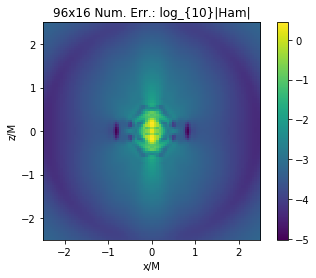

In [15]:
x96,y96,valuesCF96,valuesHam96 = np.loadtxt('out96.txt').T #Transposed for easier unpacking

pl_xmin = -2.5
pl_xmax = +2.5
pl_ymin = -2.5
pl_ymax = +2.5

grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points96 = np.zeros((len(x96), 2))
for i in range(len(x96)):
    points96[i][0] = x96[i]
    points96[i][1] = y96[i]

grid96 = griddata(points96, valuesCF96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesCF96, (grid_x, grid_y), method='cubic')

grid96 = griddata(points96, valuesHam96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesHam96, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("96x16 Num. Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("z/M")

fig96cub = plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cub)

<Figure size 432x288 with 0 Axes>

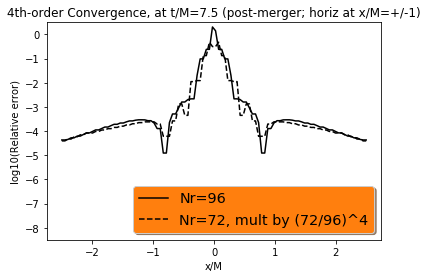

In [16]:
x72,y72,valuesCF72,valuesHam72 = np.loadtxt('out72.txt').T #Transposed for easier unpacking
points72 = np.zeros((len(x72), 2))
for i in range(len(x72)):
    points72[i][0] = x72[i]
    points72[i][1] = y72[i]

grid72 = griddata(points72, valuesHam72, (grid_x, grid_y), method='nearest')

griddiff_72_minus_96 = np.zeros((100,100))
griddiff_72_minus_96_1darray = np.zeros(100*100)
gridx_1darray_yeq0 = np.zeros(100)
grid72_1darray_yeq0 = np.zeros(100)
grid96_1darray_yeq0 = np.zeros(100)
count = 0
for i in range(100):
    for j in range(100):
        griddiff_72_minus_96[i][j] = grid72[i][j] - grid96[i][j]
        griddiff_72_minus_96_1darray[count] = griddiff_72_minus_96[i][j]
        if j==49:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid72_1darray_yeq0[i] = grid72[i][j] + np.log10((72./96.)**4)
            grid96_1darray_yeq0[i] = grid96[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("4th-order Convergence, at t/M=7.5 (post-merger; horiz at x/M=+/-1)")
plt.xlabel("x/M")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid96_1darray_yeq0, 'k-', label='Nr=96')
ax.plot(gridx_1darray_yeq0, grid72_1darray_yeq0, 'k--', label='Nr=72, mult by (72/96)^4')
ax.set_ylim([-8.5,0.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()